In [1]:
import pickle as pkl
with open("../resources/final_data.pickle","rb") as pkl_in:
    en_pt_data_original = pkl.load(pkl_in)
    en_de_data_original = pkl.load(pkl_in)
    en_pt_data = pkl.load(pkl_in)
    en_de_data = pkl.load(pkl_in)
    data_original_ft = pkl.load(pkl_in)
    data_original_bert = pkl.load(pkl_in)
    data = pkl.load(pkl_in)

In [2]:
#separating unannotated from human annotated data (unscored data from scored)
unscored_data = {k : v for k, v in data_original_bert.items() if data_original_bert[k]['y'] == 10.0}
data = {k : v for k, v in data_original_bert.items() if data_original_bert[k]['y'] != 10.0}
len(unscored_data), len(data)

(276, 61)

In [5]:
def lin_reg(X_train, y_train):
    
    from sklearn.linear_model import LinearRegression
    
    parameters = {'fit_intercept':[True], 'normalize':[False], 'copy_X':[True]}
    
    reg = GridSearchCV(LinearRegression(), parameters, scoring = "neg_mean_squared_error", cv=5)
    reg.fit(X_train, y_train)
    
    return reg.best_estimator_, reg.best_params_, reg.best_score_

In [6]:
def svm_reg(X_train, y_train):
    
    print(len(X_train))
    
    from sklearn.svm import SVR

    parameters = {"C": [0.001, 0.01, 0.1, 1, 10], "gamma": np.logspace(-2, 2, 5)}
    #parameters = {"C":[1], "gamma":['auto']}
    reg = GridSearchCV(SVR(kernel = "rbf"), parameters, scoring = "neg_mean_squared_error", cv=5)
    reg.fit(X_train, y_train)
    
    return reg.best_estimator_, reg.best_params_, reg.best_score_

In [7]:
def rf_reg(X_train, y_train):
    
    from sklearn.ensemble import RandomForestRegressor
    parameters = {'n_estimators': [6]}
    
    reg = GridSearchCV(RandomForestRegressor(random_state = 42), parameters, scoring = "neg_mean_squared_error", cv=5)
    reg.fit(X_train, y_train)
    
    return reg.best_estimator_, reg.best_params_, reg.best_score_

In [8]:
def mlp_reg(X_train, y_train):
    
    from sklearn.neural_network import MLPRegressor
    parameters = {'max_iter': [500,1000], 'alpha': 10.0 ** -np.arange(1, 5), 'hidden_layer_sizes':(np.arange(5, 10))}
    
    reg = GridSearchCV(MLPRegressor(random_state = 42), parameters, scoring = "neg_mean_squared_error", cv=5)
    reg.fit(X_train, y_train)
    
    return reg.best_estimator_, reg.best_params_, reg.best_score_

In [9]:
def scores(y_true, y_pred, type_):
    
    from sklearn.metrics import mean_squared_error
    
    mse = mean_squared_error(y_true, y_pred)    #mse
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))     #rmse
    coef = np.corrcoef([np.array(y_true).astype(float), np.array(y_pred).astype(float)])[1,0]  #Pearson product-moment correlation coefficients
    
    print("Results for ", type_)
    print("RMSE : ", round(rmse, 4), "MSE : ", round(mse, 4), "Pearson Correlation Coefficient : ", round(coef, 4) )
    
    return round(mse, 4), round(rmse, 4), round(coef, 4)

In [10]:
def get_X_Y(df, split):
    
    y = df['y'].values
    del df['y']
    x = df.values
    #linear regressor doesn't take 3d input
    x = [[np.average(x[i][j]) for j in range(len(x[i]))] for i in range(len(x))]
    x = np.array(x)
    
    #train-test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = split, random_state=42)
    print('Size of Train Size : ', len(X_train))
    print('Size of Test Size :', len(X_test))
    
    return X_train, X_test, y_train, y_test

In [11]:
def learner(model, X_train, y_train, sample, model_name):
        
        df = pd.DataFrame(sample).T
        del df['y']
        x = df.values
        
        #linear regressor doesn't take 3d input
        x = [[np.average(x[i][j]) for j in range(len(x[i]))] for i in range(len(x))]
        x = np.array(x)
        
        y = model.predict(x)
        
        if model_name == 'svm' :
            best_model, best_params, best_score = svm_reg(np.concatenate((X_train, x), axis = 0), np.concatenate((y_train, y), axis = 0))
        elif model_name == 'lr':
            best_model, best_params, best_score = lin_reg(np.concatenate((X_train, x), axis = 0), np.concatenate((y_train, y), axis = 0))
        elif model_name == 'rf':
            best_model, best_params, best_score = rf_reg(np.concatenate((X_train, x), axis = 0), np.concatenate((y_train, y), axis = 0))
        elif model_name == 'mlp' :
            best_model, best_params, best_score = mlp_reg(np.concatenate((X_train, x), axis = 0), np.concatenate((y_train, y), axis = 0))

        return x, y, best_score, best_model

In [12]:
from itertools import islice
def chunks(un_data, n):
    it = iter(un_data)
    for i in range(0, len(un_data)):
        yield {k:un_data[k] for k in islice(it, n)}

In [13]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

def iterative_learner(model_name, bin_copy, X_train, y_train) :
    
    print(len(X_train), len(y_train))
    if model_name == 'svm' :
        best_model, best_params, best_score = svm_reg(X_train, y_train)
    elif model_name == 'lr':
        best_model, best_params, best_score = lin_reg(X_train, y_train)
    elif model_name == 'rf':
        best_model, best_params, best_score = rf_reg(X_train, y_train)
    elif model_name == 'mlp' :
        best_model, best_params, best_score = mlp_reg(X_train, y_train)
    
    mse = []
    
    while(len(bin_copy) > 0):
        trials = []
        X_trials = []
        y_trials = []
        models = []
        
        for i in range(len(bin_copy)):
            
            X_train_trial, y_train_trial, score, model = learner(best_model, X_train, y_train, bin_copy[i], model_name)
            trials.append(score)
            X_trials.append(X_train_trial)
            y_trials.append(y_train_trial)
            models.append(model)

        mse.append(-(max(trials)))   #mse
        
        print(trials, max(trials), trials.index(max(trials)))   #max as negated values returned by neg_mean_squared_error
        X_train = np.concatenate((X_train, X_trials[trials.index(max(trials))]), axis = 0)
        y_train = np.concatenate((y_train, y_trials[trials.index(max(trials))]), axis = 0)
        best_model = models[trials.index(max(trials))]
        
        del bin_copy[trials.index(max(trials))]
        
        
    return best_model, mse


In [14]:
def get_bins():
    bins = []
    for item in chunks(unscored_data, 46):
        bins.append(item)

    bins = [d for d in bins if len(d) > 0]
    len(bins)
    return bins

In [15]:
X_train, X_test, y_train, y_test = get_X_Y(pd.DataFrame(data).T, 0.33)

Size of Train Size :  40
Size of Test Size : 21


In [16]:
bin_copy = get_bins()
best_model_, mse_lr = iterative_learner("lr", bin_copy, X_train, y_train)
print(best_model_)
y_pred = best_model_.predict(X_test)
mse_test_lr, rmse_test_lr, corel_test_lr = scores(y_test, y_pred, "test")

40 40
[-0.004869378901811741, -0.004881926280094289, -0.004933198907592922, -0.005149949642931243, -0.0048978391602419675, -0.004864520114538649] -0.004864520114538649 5
[-0.0030861284846752522, -0.0030763780964225317, -0.0031326180658666687, -0.0032229560936673928, -0.0030984264388534857] -0.0030763780964225317 1
[-0.0021159232565405623, -0.0021172499894865186, -0.002119097396259719, -0.0021190012534423345] -0.0021159232565405623 0
[-0.0016553699222411514, -0.0016553699222411516, -0.0016553699222411516] -0.0016553699222411514 0
[-0.0013733439354889556, -0.0013733439354889556] -0.0013733439354889556 0
[-0.0011734267803228415] -0.0011734267803228415 0
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Results for  test
RMSE :  0.1528 MSE :  0.0233 Pearson Correlation Coefficient :  0.4513


In [17]:
bin_copy = get_bins()
best_model_, mse_svm = iterative_learner("svm", bin_copy, X_train, y_train)
print(best_model_)
y_pred = best_model_.predict(X_test)
mse_test_svm, rmse_test_svm, corel_test_svm = scores(y_test, y_pred, "test")

40 40
40
86


/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


86


/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


86
86
86


/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/Debanjana/anaconda3

86
[-0.007320047648518003, -0.007408466947786034, -0.00754011869354096, -0.0073214806375867135, -0.007460205728589605, -0.007473381786413278] -0.007320047648518003 0
132


/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


132
132


/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


132


/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


132
[-0.004994325805816101, -0.005187236352094388, -0.005131526186145382, -0.005069964001686453, -0.005116858537733144] -0.004994325805816101 0


/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


178
178
178
178
[-0.0034664199058633857, -0.0035371396020089556, -0.0034674830650411378, -0.003501107331788994] -0.0034664199058633857 0
224
224
224
[-0.0026291254938159577, -0.002590160676718739, -0.002587562304784882] -0.002587562304784882 2
270
270
[-0.002232335678672807, -0.00220861890735735] -0.00220861890735735 1
316
[-0.0019666789336762257] -0.0019666789336762257 0
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=100.0,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Results for  test
RMSE :  0.1579 MSE :  0.0249 Pearson Correlation Coefficient :  0.5087


In [18]:
bin_copy = get_bins()
best_model_, mse_rf = iterative_learner("rf", bin_copy, X_train, y_train)
print(best_model_)
y_pred = best_model_.predict(X_test)
mse_test_rf, rmse_test_rf, corel_test_rf = scores(y_test, y_pred, "test")

40 40
[-0.00693111846135717, -0.007823389667858721, -0.007633387597550265, -0.007082465008206365, -0.008180871879807526, -0.006837348299449935] -0.006837348299449935 5
[-0.004183033455030318, -0.004657768331557034, -0.004909473168034308, -0.004433226843757412, -0.004466376703755449] -0.004183033455030318 0
[-0.004030575198012848, -0.003487217448782976, -0.003211901991640789, -0.0035691522027725196] -0.003211901991640789 2
[-0.002835946029967374, -0.002705407942064958, -0.0027383386128953966] -0.002705407942064958 1
[-0.002259031935836852, -0.0021527104457201504] -0.0021527104457201504 1
[-0.0019064824652069469] -0.0019064824652069469 0
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=None,
   

In [19]:
bin_copy = get_bins()
best_model_, mse_mlp = iterative_learner("mlp", bin_copy, X_train, y_train)
print(best_model_)
y_pred = best_model_.predict(X_test)
mse_test_mlp, rmse_test_mlp, corel_test_mlp = scores(y_test, y_pred, "test")

40 40


/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: Conv

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

[-0.006808441700110687, -0.006810721331856638, -0.006811900290328833, -0.006813007984770094, -0.006808557800758363, -0.00680863003293106] -0.006808441700110687 0


/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: Conv

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

[-0.004445501437533416, -0.004445802207830971, -0.00444596678258653, -0.00444493103394595, -0.004445005943444835] -0.00444493103394595 3


/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

[-0.0032748003698577096, -0.0032748019790279134, -0.0032748021172926936, -0.003274789601217269] -0.003274789601217269 3


/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

[-0.0026018031136291727, -0.0026018024325334638, -0.002601801235639366] -0.002601801235639366 2
[-0.002198045985418209, -0.002198012902467122] -0.002198012902467122 1
[-0.0018664047794402455] -0.0018664047794402455 0
MLPRegressor(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=7, learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=42, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)
Results for  test
RMSE :  0.1677 MSE :  0.0281 Pearson Correlation Coefficient :  0.2065


In [20]:
#testing it without iterative learner

model, params, reg_score_train = lin_reg(X_train, y_train)
y_pred = model.predict(X_test)
lin_mse_test, lin_rmse_test, lin_corel_test = scores(y_test, y_pred, "test")

Results for  test
RMSE :  0.1528 MSE :  0.0233 Pearson Correlation Coefficient :  0.4513


In [21]:
model, params, reg_score_train = svm_reg(X_train, y_train)
print(-(reg_score_train))
y_pred = model.predict(X_test)
svm_mse_test, svm_rmse_test, svm_corel_test = scores(y_test, y_pred, "test")

40
0.01397457962403667
Results for  test
RMSE :  0.1579 MSE :  0.0249 Pearson Correlation Coefficient :  0.5087


In [22]:
model, params, reg_score_train = rf_reg(X_train, y_train)
print(-(reg_score_train))
y_pred = model.predict(X_test)
rf_mse_test, rf_rmse_test, rf_corel_test = scores(y_test, y_pred, "test")

0.014358150667674475
Results for  test
RMSE :  0.1958 MSE :  0.0383 Pearson Correlation Coefficient :  -0.2768


In [23]:
model, params, reg_score_train = mlp_reg(X_train, y_train)
print(-(reg_score_train))
y_pred = model.predict(X_test)
mlp_mse_test, mlp_rmse_test, mlp_corel_test = scores(y_test, y_pred, "test")

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/Debanjana/anaconda3/envs/gsoc19/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

0.01475737735685079
Results for  test
RMSE :  0.1684 MSE :  0.0284 Pearson Correlation Coefficient :  0.2091


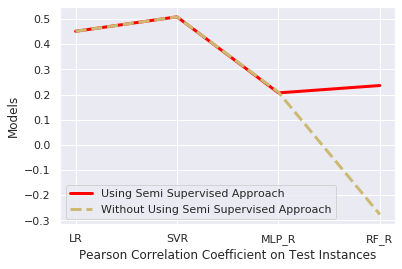

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

y = [corel_test_lr, corel_test_svm, corel_test_mlp, corel_test_rf]
x = ["LR", "SVR", "MLP_R","RF_R"]
plt.plot(x, y, color = 'red', lw = 3) 
plt.xlabel('Pearson Correlation Coefficient on Test Instances')
plt.ylabel('Models')

y = [lin_corel_test, svm_corel_test, mlp_corel_test, rf_corel_test]
x = ["LR", "SVR", "MLP_R","RF_R"]
plt.plot(x, y, "y--", lw = 3)
plt.xlabel('Pearson Correlation Coefficient on Test Instances')
plt.ylabel('Models')

types = ['Using Semi Supervised Approach', 'Without Using Semi Supervised Approach']
plt.legend(types)
plt.show()